# **LSTM - Movie Sentiment Analysis** 

The goal of this project is to construct a **movie sentiment analysis** model using the **LSTM** architecture. Our dataset is based on **IMDB Reviews** that have already been classified as *positive* and *negative* reviews. The objective is to predict whether a review is positive or negative based on the given reviews and labels. 

## **0. Settings**

Primarily, we set up our environment by connecting to Google Drive for later access to the dataset. Additionally, we import all necessary libraries in handling the data and running our model. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import all used library
import pandas as pd # read datasets

# libraries to load datasets and handle models 
import torch
import numpy as np 
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

# plotting 
import matplotlib.pyplot as pyplot

# math lib 
import math

## **1. Prepare Data for the Training Model**

In this step, we will import the dataset into this notebook and then standardardize the data for later use. 

### **1.1. Import Necessary Data**

The **IMDB Review Dataset** is a .csv file consisting of five columns: *No, type, review, label, file*. The column *type* includes two values *train* and *test*. For each review in the column *review*, there is a corresponding label *pos* or *neg* or *unsup* that facilitates our sentiment analyzing process. We will only use data from these two columns *review* and *label* and only data with either a *pos* or a *neg* label. 

In [3]:
data = pd.read_csv("/content/drive/MyDrive/NLP2022/movie_sentiments/data/imdb_master.csv", encoding='unicode_escape')

In [4]:
data.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [5]:
data.tail()

,Unnamed: 0,type,review,label,file
99995,99995,train,"Delightfully awful! Made by David Giancola, a ...",unsup,9998_0.txt
99996,99996,train,"Watching Time Chasers, it obvious that it was ...",unsup,9999_0.txt
99997,99997,train,At the beginning we can see members of Troma t...,unsup,999_0.txt
99998,99998,train,"The movie was incredible, ever since I saw it ...",unsup,99_0.txt
99999,99999,train,"TCM came through by acquiring this wonderful, ...",unsup,9_0.txt


Next, we delete redundant columns and only retain columns *'review'* and *'label'*. 

In [6]:
data = data.iloc[:, 2:4]  

We are interested in the data with predefined labels *pos* and *neg*, and so we will extract only the data with these labels. 

In [7]:
data = data[(data.label == "pos") | (data.label == "neg")] 

In [8]:
data.head()

,review,label
0,Once again Mr. Costner has dragged out a movie...,neg
1,This is an example of why the majority of acti...,neg
2,"First of all I hate those moronic rappers, who...",neg
3,Not even the Beatles could write songs everyon...,neg
4,Brass pictures (movies is not a fitting word f...,neg


### **1.2. Shuffle Data**

Since the dataset is currently arranged in an alphabetical order, it is important to shuffle the dataset so as to avoid any pattern that can affect the learning process. This is a basic rule in training deep learning model.

Particularly, if we divide the dataset into training set and validating set: about 1000 last words will be assigned into validating set. This could cause an unexpected scenario: the developed model could perform significantly bad on words beginning with 'y' or 'z' because it has never been trained to predict words like that.

We will use pandas .sample() method to shuflle the data and then reset the index so that the data does not have any information about its previous order. 

In [9]:
data = data.sample(frac = 1)        

In [11]:
data.head() # needs resetting indices

,review,label
8604,This movie suffers from the fact that for year...,neg
48118,Tressa's vocal performance was Outstanding!! T...,pos
831,I disagree 100% with the reviewer who disagree...,neg
39280,Now I had the pleasure of first viewing Contam...,pos
4658,at first i thought it was bad because i had gr...,neg


In [12]:
data = data.reset_index(drop=True) 

In [13]:
data.head()

,review,label
0,This movie suffers from the fact that for year...,neg
1,Tressa's vocal performance was Outstanding!! T...,pos
2,I disagree 100% with the reviewer who disagree...,neg
3,Now I had the pleasure of first viewing Contam...,pos
4,at first i thought it was bad because i had gr...,neg


### **1.3. Standardize Data**

The data in the *review* column consists of both uppercase and lowercase words together with punctuations and redundant html break signs. Thus, this step transforms all words into lowercase ones and then removes all unnecessary punctuations and break signs.

In [14]:
def standardizeData(input_column):
    punctuations = ['"', '!', '#', '$', '&', '\'' , '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '\\', '^', '_', '`', '{', '|', '}', '~' ]
    
    standardized_column = []
    
    for row in input_column: 
        row = row.lower()   # lowercase transformation 
        row = row.replace('<br />', ' ') # replace break signs with spaces
        for punc in punctuations: 
            row = row.replace(punc, ' ') # replace punctuations with spaces
        standardized_column.append(row)  
    return standardized_column

In [15]:
data.review = standardizeData(data.review)

We also want to convert *label*  into a numpy array of ints. 

In [33]:
labels_to_numbers = [1 if label == "pos" else 0 for label in list_of_labels]
labels = np.array(labels_to_numbers)
data['label'] = labels

In [34]:
data.head()

,review,label
0,this movie suffers from the fact that for year...,0
1,tressa s vocal performance was outstanding t...,1
2,i disagree 100% with the reviewer who disagree...,0
3,now i had the pleasure of first viewing contam...,1
4,at first i thought it was bad because i had gr...,0


## **2. Construct Model Inputs**

As the data is normalized, we will convert data into model input tensors, starting with building a dictionary of 30,000 most common words to integers and then converting each review into a vector of integers representing words in the review. Since each review is of different size, we will set a standard size to each review and pad/truncate reviews to get the same size. Finally, we partition our dataset into training, validation, and testing set and construct tensor datasets out of these sets. These sets will be the inputs for our model. 

### **2.1 Build a Dictionary of Words to Integers**

Firstly, we convert the data into a Python list. 

In [35]:
list_of_reviews = list(data["review"])
list_of_labels = list(data["label"])

With the list of reviews, we can concatenate the reviews to get a corpus of words. Next, we construct a list of words from all of the reviews and count the frequency of each word using Counter. Counter gives us a mapping of words that appear in the word list to their frequency in the corpus. 

In [36]:
corpus = ' '.join(list_of_reviews)

words_list = corpus.split()

words_freq_dict = Counter(words_list)

The corpus is made up of user-written reviews that may contain typos, slangs, etc. Thus, we will focus on the 30,000 most common words (including *OOV* representing out of vocab words) in the word list. The Counter object offers the method *most_common(n)* that returns the *n* most popular words in the dictionary. 

In [37]:
vocab_list = words_freq_dict.most_common(29999)
print(vocab_list[:10])
print(vocab_list[-10:])

[('the', 667989), ('and', 324427), ('a', 322969), ('of', 289405), ('to', 268119), ('is', 211082), ('it', 190735), ('in', 186778), ('i', 175534), ('this', 150997)]
[('hesitates', 8), ('mech', 8), ('fraternal', 8), ('harald', 8), ('zwart', 8), ('formatted', 8), ('reverses', 8), ('kingdoms', 8), ('twig', 8), ('weenick', 8)]


The list of the last 10 words in the *vocab_list* (consisting of 30,000 most common words) shows that words in our vocabulary have to appear at least 8 times. This helps us avoid unfamiliar words or typos. 

Next, we construct a dictionary that maps each word in our vocab list to an integer. For any word that is not included in our vocab, we assign a 0 representing a *OOV (out of vocab)* word. 

In [38]:
word_to_int = {word_freq_tuple[0]: id for id, word_freq_tuple in enumerate(vocab_list, 1)}
word_to_int['OOV'] = 0

### **2.2. Convert each review to a list of ints representing words** 

Now, as we have a dictionary of words to integers for our corpus, we want to construct a LoL of reviews, each inner list of which is a vector of integers representing words in each review. For any word that is not included in our vocab, we assign a 0 representing a OOV (out of vocab) word.

In [39]:
wordID_vector_by_review = []

for review in list_of_reviews:
    wordID_vector = [word_to_int[word] if word in word_to_int else 0 for word in review.split()] # list of ints representing words in the review
                                                                                                 # id = 0 if word = OOV 
    wordID_vector_by_review.append(wordID_vector)

In [40]:
print(wordID_vector_by_review[:2])

[[10, 15, 2464, 37, 1, 193, 11, 16, 154, 348, 67, 56, 2300, 14, 5, 85, 5, 4920, 2252, 2244, 16, 1, 4943, 26, 359, 332, 2858, 2216, 98, 71, 30, 709, 1787, 14757, 3199, 11, 2609, 26, 493, 28241, 2023, 2, 626, 16, 640, 201, 26, 405, 348, 105, 1566, 88, 8, 1, 170, 98, 11, 71, 109, 15593, 16, 5767, 40, 2859, 4257, 39, 6, 164, 44, 2244, 12, 104, 8, 10, 15, 11, 3510, 1, 104, 5, 29, 2081, 553, 16, 26, 109, 1, 324, 8, 26, 2858, 2216, 105, 2244, 6, 112, 753, 17, 1, 98, 109, 28, 6539, 941, 1687, 1698, 703, 100, 159, 18, 1, 13501, 6, 5642, 475, 1677, 12298, 213, 21, 361, 73, 5, 161, 17, 349, 2, 1, 1869, 1208, 200, 1, 106, 239, 6, 52, 3, 936, 4, 1, 226, 2, 462, 72, 85, 1, 106, 150, 191, 22, 297, 196, 27, 76, 127, 8, 432, 98, 1, 118, 148, 44, 1, 15, 6, 1, 2858, 2216, 2960, 1, 248, 175, 6, 1, 3473, 95, 11, 2252, 2244, 271, 122, 36, 15594, 2, 6620, 7, 578, 21, 29, 368, 1, 90, 8, 3667, 9231, 8, 1, 12861, 11, 1, 1203, 60, 418, 834, 43, 85, 5, 94, 3, 49, 2252, 2244, 15], [0, 12, 6317, 240, 13, 1389, 0, 2

As we can tell from the first two vectors, their sizes are not the same. What about the other reviews in the LoL? We can visualize this using a histogram as below: 

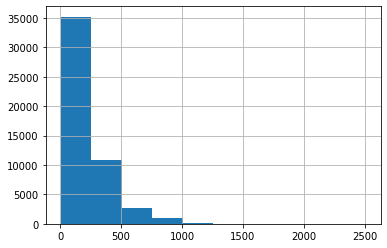

count    50000.000000
mean       235.562980
std        174.393214
min          6.000000
25%        129.000000
50%        177.000000
75%        286.000000
max       2505.000000
dtype: float64

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

review_len = [len(vector) for vector in wordID_vector_by_review]
pd.Series(review_len).hist()
plt.show()
pd.Series(review_len).describe()

Among 50,000 reviews in the dataset, the mean number of words is around 235, while the min is 6 words and the max is 2505 words in a review. The distribution of number of words in the reviews is greatly skewed right with only a small number of reviews having more than 500 words.  

### **2.3. Padding/Truncating Reviews** 

With such large variations in the length of each review, it is important to have all vectors in the same shape so as to utilize the properties of matrices. One solution for this problem is to pad or truncate the reviews.


In [42]:
def pad_and_truncate(reviews, desired_length):
    features = np.zeros((len(reviews), desired_length), dtype=int)

    for id, review in enumerate(reviews):
        
        review_len = len(review)

        if review_len <= desired_length: # fill in 0 if len(review) < desired_length 
            additional_zero = list(np.zeros(desired_length - review_len))
            new_vector = additional_zero + review
        
        else: # truncate review if len(review) > desired_length 
            new_vector = review[:desired_length]
        
        features[id, :] = new_vector

    return features

In [43]:
mean_length = 235
features = pad_and_truncate(wordID_vector_by_review, mean_length)

In [44]:
features.shape 

(50000, 235)

### **2.4. Partition Data into Training, Validation, and Test Set**

We select 9/10 of the corpus (45,000 reviews) to be training set, one half of the remaining (1/20 or 2,500 reviews) to be the validation set, and the remaining reviews (2,500 reviews) to be the test set. 


In [46]:
split_frac = 0.9
last_training_index = int(len(features) * split_frac) # last index of the training set

# split at last index of the training set
train_features, remaining_features = features[:last_training_index], features[last_training_index:] 
train_labels, remaining_labels = labels[:last_training_index], labels[last_training_index:]

In [47]:
validation_test_frac = 0.5
last_validation_index = int(len(remaining_features) * validation_test_frac) # last index of the validation set

# split at last index of the validation set
val_features, test_features = remaining_features[:last_validation_index], remaining_features[last_validation_index:]
val_labels, test_labels = remaining_labels[:last_validation_index], remaining_labels[last_validation_index:]

In [48]:
## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_features.shape), 
      "\nValidation set: \t{}".format(val_features.shape),
      "\nTest set: \t\t{}".format(test_features.shape))

			Feature Shapes:
Train set: 		(45000, 235) 
Validation set: 	(2500, 235) 
Test set: 		(2500, 235)


### **2.5. Construct Tensor Datasets**

In [49]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_features), torch.from_numpy(train_labels))
valid_data = TensorDataset(torch.from_numpy(val_features), torch.from_numpy(val_labels))
test_data = TensorDataset(torch.from_numpy(test_features), torch.from_numpy(test_labels))

In [50]:
# dataloaders
batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

## **3. Build Model** 

### **3.0. Check if GPU is Available**

In [51]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


### **3.1. Construct a LSTM Class**

In [52]:
class LSTM(nn.Module):


    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers):
        """
        Initialize the model by setting up the layers.
        """
        super(LSTM, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)

        # dropout layers
        self.dropout = nn.Dropout(0.2)

        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, 256)
        self.sig = nn.Sigmoid()


    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

### **3.2. Initialize the Model and its Parameters** 

Firstly, we will create an instance of the LSTM class, called *sentiment_LSTM*. 


In [58]:
vocab_size = len(word_to_int) + 1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 100
hidden_dim = 256
n_layers = 2

sentiment_LSTM = LSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print('LSTM \n', sentiment_LSTM)

LSTM 
 LSTM(
  (embedding): Embedding(30001, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=256, bias=True)
  (sig): Sigmoid()
)


The following cell calls the [nn.BCELoss()](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) that creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities. Moreover, it also constructs an optimizer object that will hold the current state and will update the parameters based on the computed gradients using [torch.optim](https://pytorch.org/docs/stable/optim.html). 



In [59]:
# loss and optimization functions
learning_rate = 0.0001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(sentiment_LSTM.parameters(), lr=learning_rate)

In [60]:
# training params

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip = 5 # gradient clipping

In [61]:
#use min_loss to track the best model throughout the training loop
min_val_loss = math.inf

In [62]:
#lists used for plotting losses
step_list = list()
train_loss_list = list()
val_loss_list = list()

The next cell defines the formula to calculate the accuracy of the model. 

In [63]:
def calculate_acc(output, target):
    ''' Calculates binary accuracy based
        on given predictions and target labels.

    Arguments:
        output (torch.tensor): predictions
        target (torch.tensor): target labels
    Returns:
        acc (float): binary accuracy
    '''
    output = torch.round(output)
    correct = torch.sum(output==target).float()
    acc = (correct/len(target)).item()
    return acc

## **4. Train Model**

In this step, we will run our model on our tensor datasets for 4 epochs and monitor the training loss, validation loss, and accuracy of the model in each step. 

In [64]:
# move model to GPU, if available
if(train_on_gpu):
   sentiment_LSTM.cuda()

In [65]:
sentiment_LSTM.train()

# train for some number of epochs
for e in range(epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(e + 1, epochs))
    print('Training...')

    # initialize hidden state
    h = sentiment_LSTM.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        sentiment_LSTM.zero_grad()

        # get the output from the model
        output, _ = sentiment_LSTM(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(sentiment_LSTM.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = sentiment_LSTM.init_hidden(batch_size)
            val_losses = []
            sentiment_LSTM.eval()
            accuracy = 0
            count = 0
            for inputs, labels in valid_loader:
                count += 1
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = sentiment_LSTM(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())
                accuracy += calculate_acc(output, labels)

            sentiment_LSTM.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)), 
                  "Accuracy: {:.6f}".format(accuracy/count))
            step_list.append(counter)
            train_loss_list.append(loss.item())
            val_loss_list.append(np.mean(val_losses))


======== Epoch 1 / 4 ========
Training...
Epoch: 1/4... Step: 100... Loss: 0.690946... Val Loss: 0.690266 Accuracy: 0.566000
Epoch: 1/4... Step: 200... Loss: 0.716441... Val Loss: 0.674645 Accuracy: 0.564000
Epoch: 1/4... Step: 300... Loss: 0.691403... Val Loss: 0.651562 Accuracy: 0.604400
Epoch: 1/4... Step: 400... Loss: 0.568941... Val Loss: 0.618023 Accuracy: 0.660400
Epoch: 1/4... Step: 500... Loss: 0.591271... Val Loss: 0.575095 Accuracy: 0.697200
Epoch: 1/4... Step: 600... Loss: 0.889667... Val Loss: 0.712868 Accuracy: 0.632800
Epoch: 1/4... Step: 700... Loss: 0.618028... Val Loss: 0.587079 Accuracy: 0.700400
Epoch: 1/4... Step: 800... Loss: 0.530808... Val Loss: 0.548942 Accuracy: 0.717200
Epoch: 1/4... Step: 900... Loss: 0.606999... Val Loss: 0.601610 Accuracy: 0.703200

======== Epoch 2 / 4 ========
Training...
Epoch: 2/4... Step: 1000... Loss: 0.470498... Val Loss: 0.516171 Accuracy: 0.744400
Epoch: 2/4... Step: 1100... Loss: 0.536692... Val Loss: 0.570987 Accuracy: 0.728000

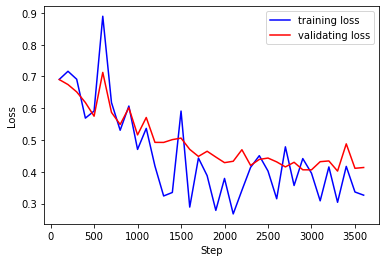

In [66]:
#Plotting loss
pyplot.plot(step_list, train_loss_list, color='blue', label='training loss')
pyplot.plot(step_list, val_loss_list, color='red', label='validating loss')
pyplot.legend()
pyplot.xlabel('Step')
pyplot.ylabel('Loss')
pyplot.show()